In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


In [2]:
import numpy.random as nr
import scipy.stats as stats
import sklearn.preprocessing as skpe
import sklearn.metrics as sklm
import sklearn.model_selection as ms
import sklearn.ensemble as ensemble
import sklearn.tree as tree
import sklearn.linear_model as lm
import sklearn.kernel_ridge as ridge
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import sklearn.pipeline as pipeline
from sklearn.compose import ColumnTransformer

In [3]:
path = "../input/insurance/insurance.csv"
data = pd.read_csv(path)
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# EDA and Visualization

**Univariate Analysis**

In [6]:
data['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

**Since, we are primarily interested in the billing charges, let's look at how it is distributed.**

Skewness: 1.515880
Kurtosis: 1.606299


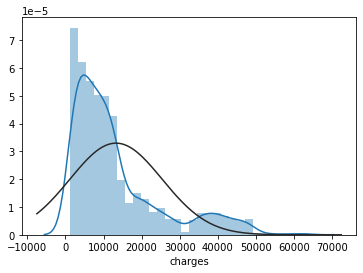

In [7]:
sns.distplot(data['charges'], hist=True, kde=True, fit=stats.norm)

# Skewness and Kurtosis
print("Skewness: %f" % data['charges'].skew())
print("Kurtosis: %f" % data['charges'].kurt())

*Looks like, it is pretty rightly skewed. We will transform this variable later in this notebook.*

**Now, we have three categorical features; sex, smoker and region ,out of which, smoker and region could have a significant impact on billing charges. So, we will encode these 3 variables and since all the three variables are nominal, hence, we will use LabelEncoder instead of OneHotEncoder.**

In [8]:
le = skpe.LabelEncoder()

# Sex
data['sex'] = le.fit_transform(data['sex'])
# Smoker
data['smoker'] = le.fit_transform(data['smoker'])
# Region
data['region'] = le.fit_transform(data['region'])

# Bivariate Analysis

**Let's start with looking at what heat map has to say.**

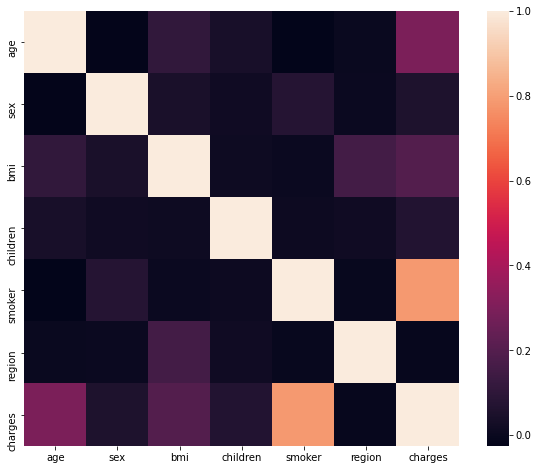

In [9]:
# Heat Map
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data.corr(), vmax=1.0, square=True, ax=ax)

In [10]:
top_features = data.corr()['charges'].sort_values()
top_features

region     -0.006208
sex         0.057292
children    0.067998
bmi         0.198341
age         0.299008
smoker      0.787251
charges     1.000000
Name: charges, dtype: float64

*Smoker is the most highly correlated feature followed by age and then bmi and I totally agree with this because SMOKING KILLS!!!. Similarly, aging leads to an increase in chances of many deadly diseases(obesity, heart problems, etc.).*

**Let's investigate further in the smoking section**

Text(0.5, 1.0, 'Distribution of charges for non-smokers')

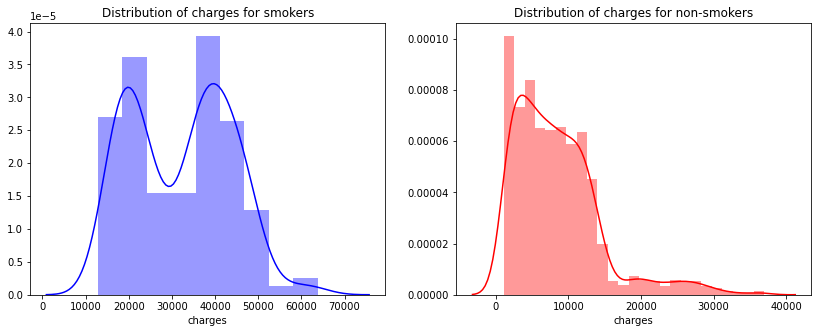

In [11]:
fig = plt.figure(figsize=(14,5))

ax = fig.add_subplot(121)
sns.distplot(data[(data['smoker'] == 1)]["charges"], color='b', ax=ax)
ax.set_title('Distribution of charges for smokers')

ax = fig.add_subplot(122)
sns.distplot(data[(data['smoker'] == 0)]['charges'], color='r', ax=ax)
ax.set_title('Distribution of charges for non-smokers')

*Patients(smoker) spend high amount of money as compared to patiients(non-smoker).*

**Now, let's look at the count of male or female with smoker or non-smoker.**

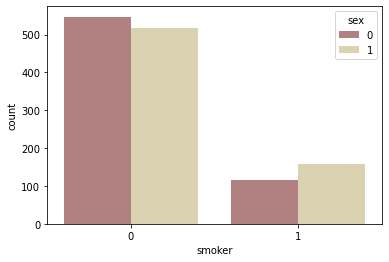

In [12]:
# Women are coded as '1' and men as '0'
sns.countplot(x="smoker", hue = 'sex', palette="pink", data=data)

*Since men are more prone to the habit of smoking than women, it is assumed that the charges might rise in case of men.*

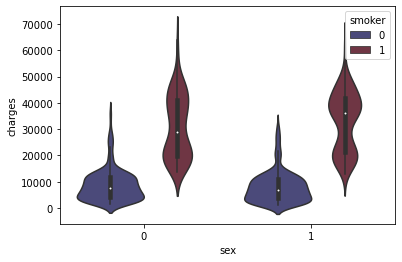

In [13]:
sns.violinplot(x="sex", y="charges", hue="smoker", data=data, palette = 'icefire')

*Clearly, we can see that there is a significant difference in the range of female non-smokers and male smokers.*

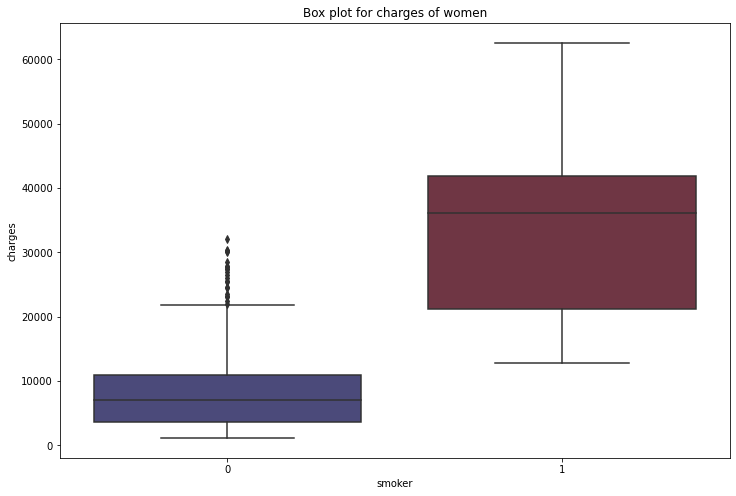

In [14]:
# Let's looka the IQR and median for female patients
plt.figure(figsize=(12,8))
plt.title("Box plot for charges of women")
sns.boxplot(x="smoker", y="charges", data=data[(data['sex'] == 1)], palette = 'icefire')

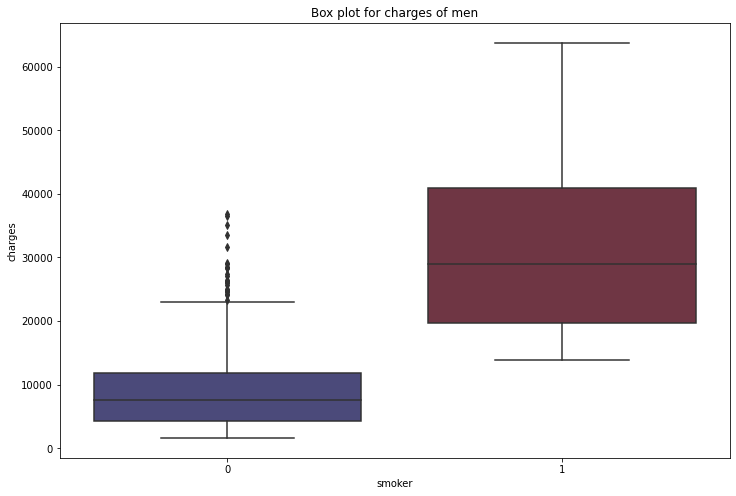

In [15]:
# Let's looka the IQR and median for male patients
plt.figure(figsize=(12,8))
plt.title("Box plot for charges of men")
sns.boxplot(x="smoker", y="charges", data=data[(data['sex'] == 0)], palette = 'icefire')

*The median for male and female non-smokers is almost same while the same for female smokers is around 35000 and for male smokers, it is slighlty below 30000*.

**Let's check the age distribution.**

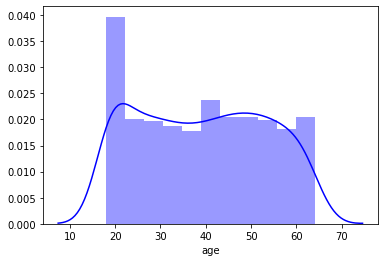

In [16]:
sns.distplot(data["age"], color = 'b')

*Looks like there are many 18 yr old patients admiitted. Let's dive deep into this.*

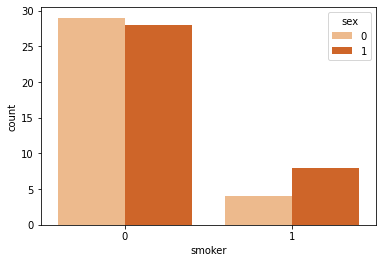

In [17]:
# data for 18 yr old
sns.countplot(x="smoker", hue = 'sex', palette="Oranges", data=data[data['age']==18])

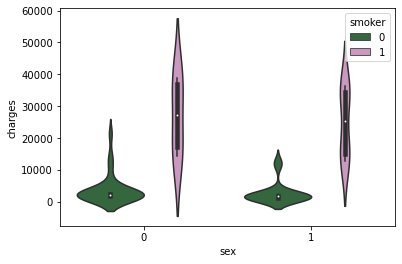

In [18]:
sns.violinplot(x="sex", y="charges", hue="smoker", data=data[data['age']==18], palette = 'cubehelix')

*Even the teens are paying around 50k billing charges.*

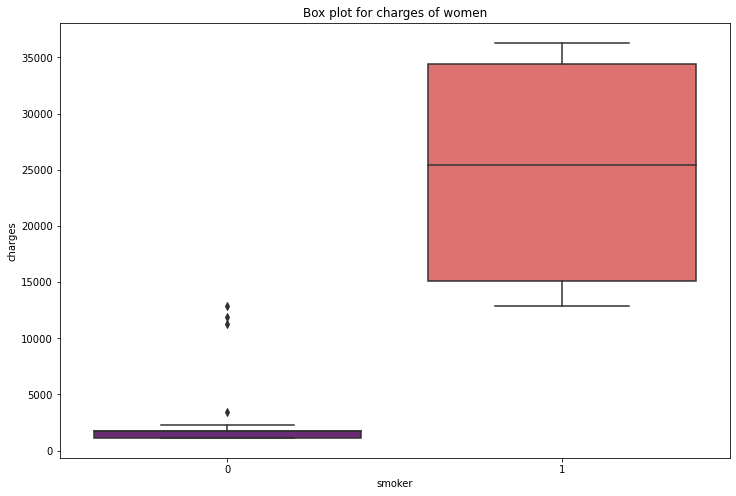

In [19]:
# Let's looka the IQR and median for female teen patients
plt.figure(figsize=(12,8))
plt.title("Box plot for charges of women")
sns.boxplot(x="smoker", y="charges", data=data[((data['sex'] == 1) & (data['age'] == 18))], palette = 'magma')

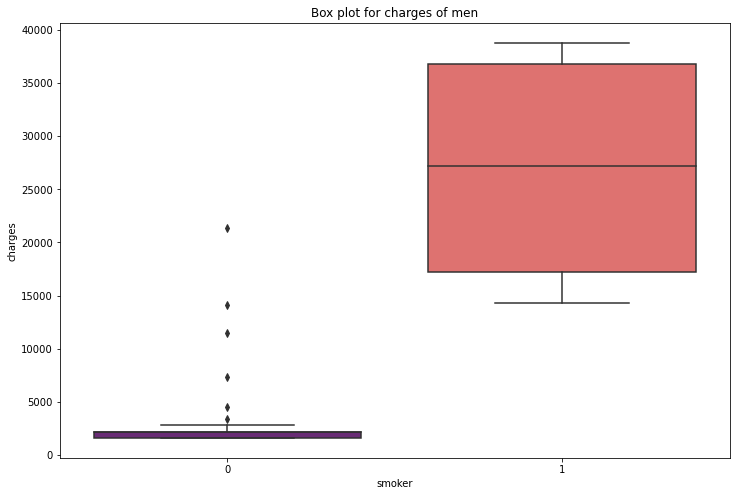

In [20]:
# Let's looka the IQR and median for male teen patients
plt.figure(figsize=(12,8))
plt.title("Box plot for charges of men")
sns.boxplot(x="smoker", y="charges", data=data[((data['sex'] == 0) & (data['age'] == 18))], palette = 'magma')

*Even at this age, teens are spending almost as sme as the patients above 18. This is really schocking!!*

* Bmi

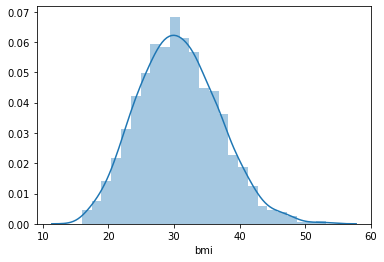

In [21]:
sns.distplot(data["bmi"])

*Ahh, finally a normal(gaussian) distribution.*

**An ideal bmi range for a person is 18.5-24.9. Lets's look at the distribution for both ideal and non-ideal range of bmi.**

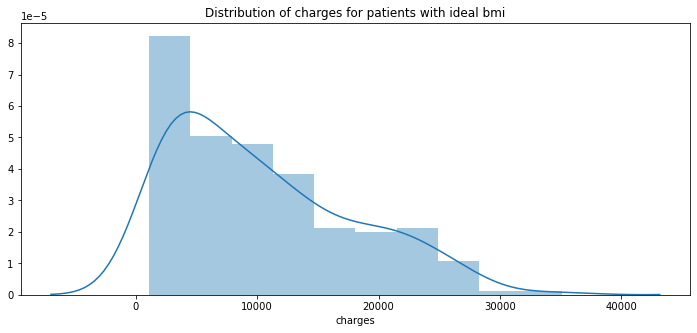

In [22]:
# ideal bmi
plt.figure(figsize=(12,5))
plt.title("Distribution of charges for patients with ideal bmi")
ax = sns.distplot(data[((data['bmi'] >= 18.5) & (data['bmi'] <= 24.9))]['charges'])

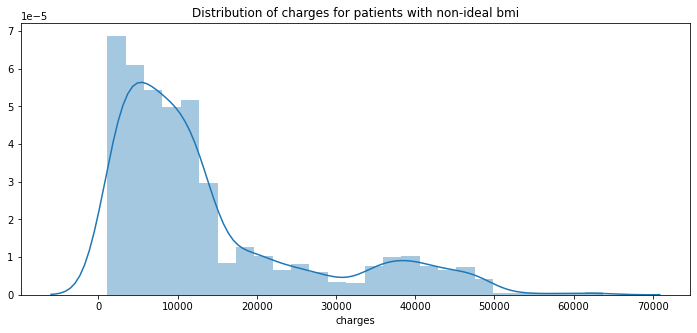

In [23]:
# non-ideal bmi
plt.figure(figsize=(12,5))
plt.title("Distribution of charges for patients with non-ideal bmi")
ax = sns.distplot(data[((data['bmi'] <= 18.5) | (data['bmi'] >= 24.9))]['charges'])

*Patients with non-ideal bmi spend more on treatment.*

**Let's look at the relationship between the top 3 correlated variables.**

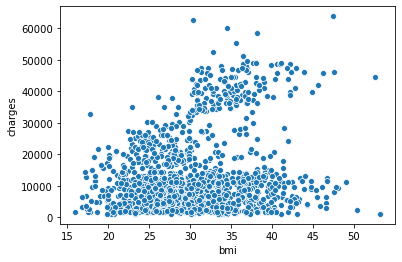

In [24]:
sns.scatterplot(y='charges', x='bmi', data=data)

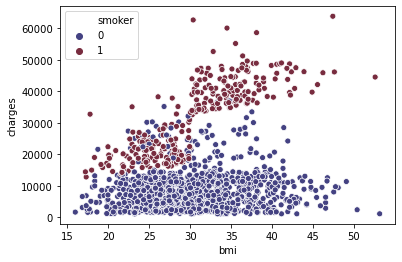

In [25]:
# Let's see how many of these are smokers
sns.scatterplot(y='charges', x='bmi', hue='smoker', palette='icefire', data=data)

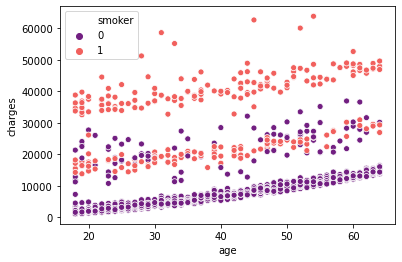

In [26]:
sns.scatterplot(y='charges', x='age', hue='smoker', palette='magma', data=data)

/opt/conda/lib/python3.7/site-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


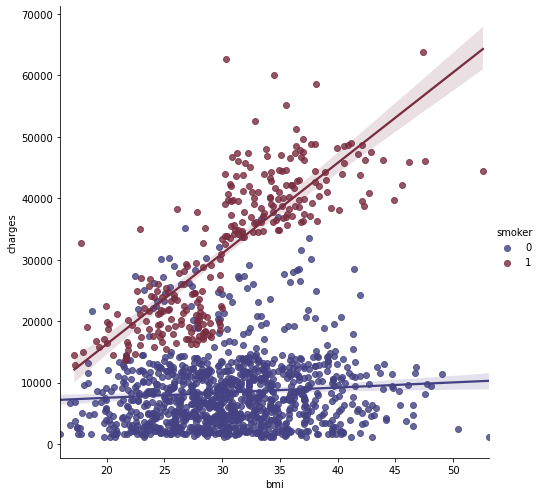

In [27]:
sns.lmplot(x="bmi", y="charges", hue="smoker", data=data, palette = 'icefire', size=7)

*We can see that the relationship between bmi and charges is almost constant for non-smokers while it is linear in case od smokers with an intercept value of around 8000.*

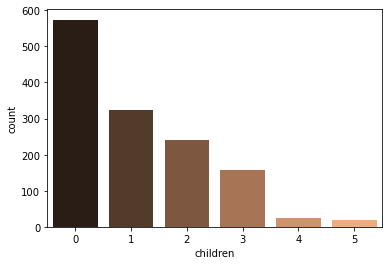

In [28]:
# No. of children patients have
sns.countplot(x="children", palette="copper", data=data)

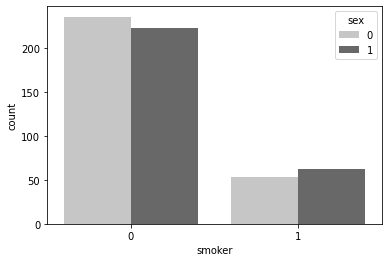

In [29]:
# Count of smokers and non smokers, male and female having no child
sns.countplot(x="smoker", hue = 'sex', palette="Greys", data=data[data['children'] == 0])

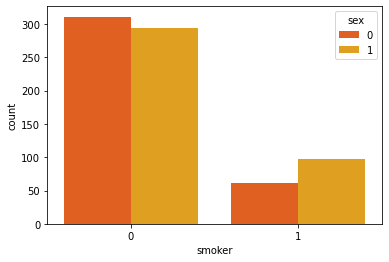

In [30]:
# Count of smokers and non smokers, male and female with atleast 1 child
sns.countplot(x="smoker", hue = 'sex', palette="autumn", data=data[data['children'] > 0])

# Handling Missing Data

In [31]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

*Hurray, no null data!!!.*

# Modelling

In [32]:
path1 = "../input/insurance/insurance.csv"
df = pd.read_csv(path1)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


**Let's make some bins for some numerical variables.**

In [33]:
# age
#bins = (17, 24, 48, 65)
#groups = ['Youth', 'Adult', 'Seniors']
#df['age_group'] = pd.cut(df['age'], bins=bins, labels=groups)

# bmi
#bins = (15, 18.5, 24.9, 30, 54)
#groups = ['Under_wt', 'Normal_wt', 'Over_wt', 'Obese'] # Underweight, Normal weight, Over weight and Obese
#df['bmi_group'] = pd.cut(df['bmi'], bins=bins, labels=groups)

*I was thinking to make one more group for children, but I am confused. So, let me know if you have any ideas about this, I would love to implement your ideas in my notebook.*

In [34]:
# Dummifying data
df = pd.get_dummies(df)
df.shape

(1338, 12)

# Modelling 

In [35]:
# seperating independent and dependent variables
X = df.drop(['charges'], axis=1).values
y = df['charges'].values.reshape(-1,1)

In [36]:
# train_test split
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=21)
X_train.shape, X_test.shape

((1070, 11), (268, 11))

* Linear Regression

In [37]:
lr = lm.LinearRegression(normalize=True)
lr.fit(X_train, y_train)

# Cross Validation Score 
cv_score = ms.cross_val_score(estimator=lr, X=X_train, y=y_train, cv = 10)

# R2 Score from train set
y_pred = lr.predict(X_train)
r2_train = sklm.r2_score(y_train, y_pred)

# R2 Score from test set
y_pred_test = lr.predict(X_test)
r2_test = sklm.r2_score(y_test, y_pred_test)

# RMSE score
rmse = np.sqrt(sklm.mean_squared_error(y_test, y_pred_test))

# printing all stats
print("CV Score {} and standard deviation {}: ".format(cv_score.mean(), cv_score.std()))
print('R2_score (train): ', r2_train)
print('R2_score (test): ', r2_test)
print("RMSE: ", rmse)

CV Score 0.7459869831909396 and standard deviation 0.041655907248714194: 
R2_score (train):  0.7544455313041668
R2_score (test):  0.7333045867702144
RMSE:  6084.908179066211


In [38]:
# Feature Scaling
sc_X = skpe.StandardScaler()
sc_y = skpe.StandardScaler()
X_scaled = sc_X.fit_transform(X)
y_scaled = sc_y.fit_transform(y.reshape(-1,1))

* Decision Tree

In [39]:
# Hypreparamter Tuning
param_dist = {'criterion':['gini', 'mse', 'entropy'], 'max_depth':stats.randint(1,10)
              , 'min_samples_split':stats.randint(1,10), 'min_samples_leaf':stats.randint(1,15)}
clf = tree.DecisionTreeRegressor(random_state=23)
clf_cv = ms.RandomizedSearchCV(clf, param_distributions=param_dist, cv=10)
clf_cv.fit(X_scaled, y_scaled)
print("Tuned Decision Tree Parameters: {}".format(clf_cv.best_params_)) 
print("Best score is {}".format(clf_cv.best_score_)) 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 1246, in fit
    X_idx_sorted=X_idx_sorted)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 336, in fit
    criterion = CRITERIA_REG[self.criterion](self.n_outputs_,
KeyError: 'entropy'

  FitFailedWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/li

Tuned Decision Tree Parameters: {'criterion': 'mse', 'max_depth': 6, 'min_samples_leaf': 13, 'min_samples_split': 8}
Best score is 0.8513604844782197


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 1246, in fit
    X_idx_sorted=X_idx_sorted)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 231, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 


In [40]:
# Cross validation Score
cv_score = clf_cv.best_score_

# R2 Score from train set
y_pred = sc_y.inverse_transform(clf_cv.predict(sc_X.transform(X_train)))
r2_train = sklm.r2_score(y_train, y_pred)

# R2 Score from test set
y_pred_test = sc_y.inverse_transform(clf_cv.predict(sc_X.transform(X_test)))
r2_test = sklm.r2_score(y_test, y_pred_test)

# RMSE score
rmse = (np.sqrt(sklm.mean_squared_error(y_test, y_pred_test)))

# printing all stats
print("CV Score {} and standard deviation {}: ".format(cv_score.mean(), cv_score.std()))
print('R2_score (train): ', r2_train)
print('R2_score (test): ', r2_test)
print("RMSE: ", rmse)

CV Score 0.8513604844782197 and standard deviation 0.0: 
R2_score (train):  0.8877332569820672
R2_score (test):  0.8626949695667255
RMSE:  4366.0577942648015


* Random Forest

In [41]:
# Hyperparamter Tuning
param_dist = {'n_estimators':[200, 400, 600, 800, 1000, 1200], 'max_depth':stats.randint(1,12)
              , 'max_features':['auto'], 'min_samples_leaf':stats.randint(1,11), 'min_samples_split':stats.randint(1,14)}
clf = ensemble.RandomForestRegressor(random_state=23)
clf_cv = ms.RandomizedSearchCV(clf, param_distributions=param_dist, cv=10)
clf_cv.fit(X_scaled, y_scaled)
print("Tuned Random Forest Parameters: {}".format(clf_cv.best_params_)) 
print("Best score is {}".format(clf_cv.best_score_)) 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 

Tuned Random Forest Parameters: {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 600}
Best score is 0.859736787562561


In [42]:
# Cross Validation Score
cv_score = clf_cv.best_score_

# R2 Score from train set
y_pred = sc_y.inverse_transform(clf_cv.predict(sc_X.transform(X_train)))
r2_train = sklm.r2_score(y_train, y_pred)

# R2 Score from test set
y_pred_test = sc_y.inverse_transform(clf_cv.predict(sc_X.transform(X_test)))
r2_test = sklm.r2_score(y_test, y_pred_test)

# RMSE score
rmse = (np.sqrt(sklm.mean_squared_error(y_test, y_pred_test)))

# printing all stats
print("CV Score {} and standard deviation {}: ".format(cv_score.mean(), cv_score.std()))
print('R2_score (train): ', r2_train)
print('R2_score (test): ', r2_test)
print("RMSE: ", rmse)

CV Score 0.859736787562561 and standard deviation 0.0: 
R2_score (train):  0.8879660823773925
R2_score (test):  0.8683508699330732
RMSE:  4275.188347041131


# Conclusion

*We made three models, hypertuned them and then calculated their cross-val-score, R2_score(train & test) and RMSE score. If you liked this notebook, please hit the upvote button and comment down if you have any suggestion of how can I improve. THANK YOU!!*